In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import math
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
def calc_di(distances, k, d_bar=True):
    di = distances.apply(lambda x: x.nsmallest(k).mean()).values
    return (di, di.mean()) if d_bar else di    

In [3]:
def cloud(references, tests, k):
    """
    reference: pd.DataFrame
        Should represent a distance matrix where rows and columns are indexed by reference sample ids
    tests: pd.DataFrame
        Should represent a distance matrix where row are indexed by reference sample ids and columns are indexed
        by tests sample ids
    k: int
        The number of k nearest neighbors to look at
    """
    reference_ids = references.columns.to_list()
    test_ids = tests.columns.to_list()
    # step 1 and 2
    r_di, d_bar = calc_di(references, k)
    
    # step 3
    r_ri = r_di / d_bar
    
    # step 4
    t_di = calc_di(tests, k, d_bar=False)
    t_ri = t_di / d_bar
    
    for i, t in enumerate(t_ri):
        e = np.sum(r_ri >= t)
        t_ri[i] = e
    t_ri = t_di / r_ri.shape[0]
    
    return (t_di)

In [4]:
def cloud1(references, tests, k):
    """
    reference: pd.DataFrame
        Should represent a distance matrix where rows and columns are indexed by reference sample ids
    tests: pd.DataFrame
        Should represent a distance matrix where row are indexed by reference sample ids and columns are indexed
        by tests sample ids
    k: int
        The number of k nearest neighbors to look at
    """
    reference_ids = references.columns.to_list()
    test_ids = tests.columns.to_list()
    # step 1 and 2
    r_di, d_bar = calc_di(references, k)
    
    # step 3
    r_ri = r_di / d_bar
    
    # step 4
    t_di = calc_di(tests, k, d_bar=False)
    t_ri = t_di / d_bar
        
    return (t_di)

In [5]:
def get_reference_set(distances, samples, ref_lam, s_r, p_k, num_samplings=10):
    # get full "normal" set
    distances = distances.loc[ref_lam(samples)]
    distances = distances[distances.index]
    
    # calculate k
    size = int(distances.shape[0] * s_r)
    k = int(p_k * size)
    _, d_bar = calc_di(distances, k)
    
    # find s_bar closest to d_bar
    best_ref = None
    best_bar_sep = np.inf
    for _ in range(num_samplings):
        ref_distances = distances.sample(size)
        ref_distances = ref_distances[ref_distances.index]
        _, s_bar = calc_di(ref_distances, k)
        s_bar_dist = s_bar - d_bar
        if s_bar_dist < best_bar_sep:
            best_ref = ref_distances
            best_bar_sep = s_bar_dist
    return (best_ref, k)

In [6]:
def get_ref_train_test(distances, samples, ref_lam, anom_lam, s_r, p_k):
    # get reference set
#     reference_distances = distances.loc[ref_lam(samples)]
#     reference_distances = reference_distances.sample(int(reference_distances.shape[0]*.6))
#     reference_distances = reference_distances[reference_distances.index]
    reference_distances, k = get_reference_set(distances, samples, ref_lam, s_r, p_k)
    ref_ids = np.array(reference_distances.index.to_list())
    
    # get train set
    train_set_distances = distances.loc[
        (anom_lam(samples)) & ~(samples.index.isin(ref_ids)),
        ref_ids
    ]
    train_set_distances = train_set_distances.sample(int(train_set_distances.shape[0]*.8))
    train_set_ids = train_set_distances.index.to_list()
    train_set_distances = train_set_distances.T
    
    test_set_distances = distances.loc[
        (anom_lam(samples)) & ~(samples.index.isin(np.concatenate((ref_ids, train_set_ids)))),
        reference_distances.index.to_list()
    ].T
    return (reference_distances, train_set_distances, test_set_distances, k)

In [7]:
distances = pd.read_csv("artifact_110218_021021-144748/BIOM/110218/distance-matrix.tsv", sep="\t", index_col=0)
distances = distances.replace(0, np.nan)
distance_ids = distances.index.to_list()
samples = pd.read_csv("artifact_110218_021021-144748/BIOM/110218/sample.tsv", sep="\t", index_col=0)
samples = samples.loc[distance_ids]
samples["gut"] = samples.env_package == "human-gut"
samples["skin"] = samples.env_package == "human-skin"
samples["oral"] = samples.env_package == "human-oral"

In [8]:
faith = pd.read_csv("artifact_110218_021021-144748/BIOM/110218/alpha-diversity.tsv", sep="\t", index_col=0)
faith

,faith_pd
57915.550.L2S340.s.2.sequence,4.552995
57915.550.L2S64.s.2.sequence,10.117941
57915.550.L6S270.s.6.sequence,7.658321
57915.550.L6S111.s.6.sequence,8.481022
57915.550.L4S40.s.4.sequence,18.251781
...,...
57915.550.L6S27.s.6.sequence,6.572931
57915.550.L2S162.s.2.sequence,10.437967
57915.550.L2S203.s.2.sequence,9.101043
57915.550.L6S87.s.6.sequence,6.737035


# AUC for m3 vs f4

0.7662337662337663


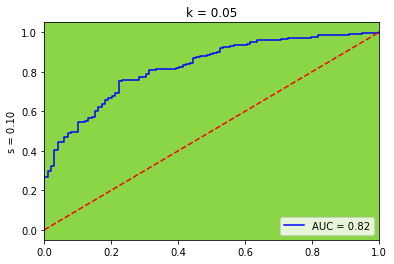

In [9]:
fig, axs = plt.subplots(1,1)
sizes = [0] * 1
ks = [0] * 1
aucs = np.zeros((1, 1))  
viridis = cm.get_cmap("viridis")
# viridis()
for i in range(1, 2):
    for j in range(1, 2):
        ref_dist, train_dist, test_dist, k = get_ref_train_test(
            distances,
            samples,
            lambda df: (df.host == "M3"),
            lambda df: (df.host == "M3") | (df.host == "F4"),
            0.3,
            0.05
        )
        train_ids = train_dist.columns.to_list()
        test_ids = test_dist.columns.to_list()

        x1 = np.array(cloud(ref_dist, train_dist, k)).reshape(-1,1)
        x2 = faith.loc[train_dist.columns].values.reshape(-1,1)
        x3 = samples.loc[train_dist.columns, "gut"].values.reshape(-1,1)
        x4 = samples.loc[train_dist.columns, "oral"].values.reshape(-1,1)
        x5 = samples.loc[train_dist.columns, "skin"].values.reshape(-1,1)
        
        x = np.hstack((x1,x2,x3,x4,x5))
        y = samples.loc[train_ids, "host"] == "M3"
        y = np.array(y.to_list())
        y = y.reshape(y.size,)

        mdl = LogisticRegression()
        mdl = mdl.fit(x,y)

        x1 = np.array(cloud(ref_dist, test_dist, k)).reshape(-1,1)
        x2 = faith.loc[test_dist.columns].values.reshape(-1,1)
        x3 = samples.loc[test_dist.columns, "gut"].values.reshape(-1,1)
        x4 = samples.loc[test_dist.columns, "oral"].values.reshape(-1,1)
        x5 = samples.loc[test_dist.columns, "skin"].values.reshape(-1,1)
        x = np.hstack((x1,x2, x3,x4,x5))
        y = samples.loc[test_ids, "host"] == "M3"
        y = np.array(y.to_list())
        y = y.reshape(y.size,)
        probs = mdl.predict_proba(x)
        print(mdl.score(x, y))
        preds = probs[:,1]
        fpr, tpr, thres = metrics.roc_curve(y, preds)
        roc_auc = metrics.auc(fpr, tpr)

        axs.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        axs.legend(loc = 'lower right')
        axs.plot([0, 1], [0, 1],'r--')
        axs.set_xlim([0, 1])
        axs.set_xlim([0, 1])

        sizes[i-1] = i * 0.1
        ks [j-1] = j * 0.05
        aucs[i-1, j-1] = roc_auc

b_colors = viridis(aucs)
for i in range(1, 2):
    for j in range(1, 2):
        axs.set_facecolor(b_colors[i-1,j-1])
        
for i in range(1):
    axs.set_ylabel("s = %0.2f" % sizes[i])
        
for j in range(1):
    axs.set_title("k = %0.2f" % ks[j])

# # Hide x labels and tick labels for top plots and y ticks for right plots.
#

0.7662337662337663


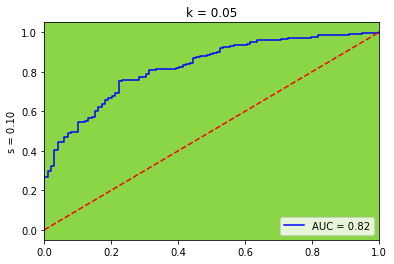

In [10]:
fig, axs = plt.subplots(1,1)
sizes = [0] * 1
ks = [0] * 1
aucs = np.zeros((1, 1))  
viridis = cm.get_cmap("viridis")
# viridis()
for i in range(1, 2):
    for j in range(1, 2):
#         ref_dist, train_dist, test_dist, k = get_ref_train_test(
#             distances,
#             samples,
#             lambda df: (df.host == "M3"),
#             lambda df: (df.host == "M3") | (df.host == "F4"),
#             0.3,
#             0.05
#         )
#         train_ids = train_dist.columns.to_list()
#         test_ids = test_dist.columns.to_list()

        x1 = np.array(cloud1(ref_dist, train_dist, k)).reshape(-1,1)
        x2 = faith.loc[train_dist.columns].values.reshape(-1,1)
        x3 = samples.loc[train_dist.columns, "gut"].values.reshape(-1,1)
        x4 = samples.loc[train_dist.columns, "oral"].values.reshape(-1,1)
        x5 = samples.loc[train_dist.columns, "skin"].values.reshape(-1,1)
        
        x = np.hstack((x1,x2,x3,x4,x5))
        y = samples.loc[train_ids, "host"] == "M3"
        y = np.array(y.to_list())
        y = y.reshape(y.size,)

        mdl = LogisticRegression()
        mdl = mdl.fit(x,y)

        x1 = np.array(cloud(ref_dist, test_dist, k)).reshape(-1,1)
        x2 = faith.loc[test_dist.columns].values.reshape(-1,1)
        x3 = samples.loc[test_dist.columns, "gut"].values.reshape(-1,1)
        x4 = samples.loc[test_dist.columns, "oral"].values.reshape(-1,1)
        x5 = samples.loc[test_dist.columns, "skin"].values.reshape(-1,1)
        x = np.hstack((x1,x2, x3,x4,x5))
        y = samples.loc[test_ids, "host"] == "M3"
        y = np.array(y.to_list())
        y = y.reshape(y.size,)
        probs = mdl.predict_proba(x)
        print(mdl.score(x, y))
        preds = probs[:,1]
        fpr, tpr, thres = metrics.roc_curve(y, preds)
        roc_auc = metrics.auc(fpr, tpr)

        axs.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        axs.legend(loc = 'lower right')
        axs.plot([0, 1], [0, 1],'r--')
        axs.set_xlim([0, 1])
        axs.set_xlim([0, 1])

        sizes[i-1] = i * 0.1
        ks [j-1] = j * 0.05
        aucs[i-1, j-1] = roc_auc

b_colors = viridis(aucs)
for i in range(1, 2):
    for j in range(1, 2):
        axs.set_facecolor(b_colors[i-1,j-1])
        
for i in range(1):
    axs.set_ylabel("s = %0.2f" % sizes[i])
        
for j in range(1):
    axs.set_title("k = %0.2f" % ks[j])

# # Hide x labels and tick labels for top plots and y ticks for right plots.
#